### **Importação das bibliotecas necessárias**

In [1]:
import os
import cv2
import random
import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.applications import ResNet50, VGG16, Xception
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, concatenate, add
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import log_loss, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

### **Leitura e pre-processamentos dos dados**

In [2]:
train_generator = ImageDataGenerator(rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

test_generator = ImageDataGenerator(rescale=1.0/255)

validation_generator = test_generator.flow_from_directory(
        '/kaggle/input/mmtcc/MM-TC/test',  
        target_size=(150,150),  
        batch_size=128,
        class_mode='binary')

train_generator = train_generator.flow_from_directory(
       '/kaggle/input/mmtcc/MM-TC/train',  
        target_size=(150,150),  
        batch_size=64,
        class_mode='binary')

Found 19175 images belonging to 2 classes.
Found 19207 images belonging to 2 classes.


## **Definindo funções de métricas de avaliação do modelo**

In [3]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [4]:
def create_model():
    model_net = VGG16(weights='imagenet', include_top=False, input_shape=(150,150, 3))
        
    model = model_net.output
    model = Flatten()(model)
    model = Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001,l2=0.001))(model)
    model = Dropout(0.5)(model)
    
    out = Dense(1, activation='sigmoid')(model)  
    model_vgg = Model(inputs=model_net.input,outputs=out)
    
    return model_vgg

In [5]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

In [6]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [7]:
model = create_model()

2021-12-01 12:40:03.779206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-01 12:40:03.884847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-01 12:40:03.885548: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-01 12:40:03.886765: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [9]:
from tensorflow.keras import regularizers

In [10]:
sgd = SGD(learning_rate=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
rms = RMSprop(learning_rate=2e-5)
    
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['acc',f1_m])

In [11]:
history = model.fit(
       train_generator,  
       epochs=30,  
       validation_data=validation_generator,
        callbacks=[learn_control, checkpoint]
)

2021-12-01 12:40:07.706446: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2021-12-01 12:40:10.381701: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


301/301 [==============================] - 486s 2s/step - loss: 26.0827 - acc: 0.6065 - f1_m: 0.7326 - val_loss: 23.0321 - val_acc: 0.4661 - val_f1_m: 0.2979

Epoch 00001: val_acc improved from -inf to 0.46613, saving model to weights.best.hdf5
Epoch 2/30
301/301 [==============================] - 215s 712ms/step - loss: 20.1621 - acc: 0.6445 - f1_m: 0.7386 - val_loss: 17.4542 - val_acc: 0.6641 - val_f1_m: 0.7100

Epoch 00002: val_acc improved from 0.46613 to 0.66409, saving model to weights.best.hdf5
Epoch 3/30
301/301 [==============================] - 212s 704ms/step - loss: 15.0399 - acc: 0.6753 - f1_m: 0.7507 - val_loss: 12.7217 - val_acc: 0.6959 - val_f1_m: 0.7384

Epoch 00003: val_acc improved from 0.66409 to 0.69591, saving model to weights.best.hdf5
Epoch 4/30
301/301 [==============================] - 198s 657ms/step - loss: 10.7190 - acc: 0.6873 - f1_m: 0.7580 - val_loss: 8.7787 - val_acc: 0.7096 - val_f1_m: 0.7961

Epoch 00004: val_acc improved from 0.69591 to 0.70957, savi

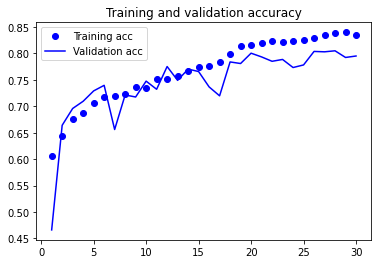

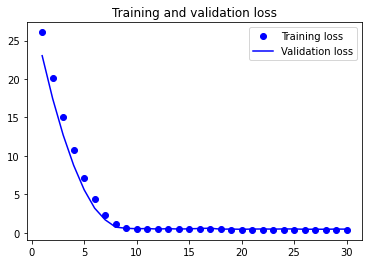

In [12]:
acc = history.history['acc'] 
  
val_acc = history.history['val_acc']  
loss = history.history['loss']
val_loss = history.history['val_loss'];
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(loc='best')

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best')


In [13]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

In [14]:
loss, acc, f1_m= model.evaluate_generator(validation_generator, 19233)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [15]:
print('Accuracy', acc)
print('f1-score', f1_m)

Accuracy 0.7952020764350891
f1-score 0.8238785862922668
